# Single-molecule translation classifier. 

This code is intended to take a video (.tiff) from fluorescence microscopy, detect single-RNA spots, track the single-RNA spots in time, and quantify spot intensity.

The code is divided in the following sections:

* Alignment images taken from the two cameras.
* Load microscope video.
* Mask selection. Manual selection of a Region Of Interest (ROI).
* Particle tracking using trackpy. http://soft-matter.github.io/trackpy/v0.4.2/
* Making crops for each detected particle.
* Calculate Intensity using the disk and donut function.
* Spot classification.
* Hand checking for the spot classification.

To run the code simply press shift + enter.

Written by Luis U. Aguilera. 03/06/2020

# Start Loading the video

In [1]:
figName = '02282020_RAN_4/MAX_Cell01.tif'   # Please change this line acording to the location of the file on your computer. Also notice that you need to use "\" in windows computers
#figName = '02282020_RAN_4/MAX_Cell03.tif'

## Load Used Modules

In [2]:
# THIS IS THE LIST OF LIBRARIES NEEDED TO RUN THE CODE. 
# Please make sure that you have them installed in your computer, in case you need to install some of them:
# open your terminal and type:
# pip install "name_of_library",
# For example, if you want to install bqplot use the following line:  pip install bqplot

import matplotlib as mpl # for plotting
import matplotlib.pyplot as plt # for plotting
import ipywidgets as widgets # for interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout,GridspecLayout
import numpy as np
from numpy import unravel_index
import pandas as pd
from pandas import DataFrame, Series  
import trackpy as tp
import cv2
from bqplot import *
import bqplot as bq
from skimage import io

# Figure size and organization

In [3]:
# Figure style and size
mpl.rc('figure',  figsize=(7, 7))
mpl.rc('image', cmap='gray')
mpl.rc('axes', grid=False)
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Image alignment. Transformation

Our microscope uses two different cameras. One of the cameras take images from the RNA (Red channel) and the other for the protein (Green and Blue). For that reason, we need to perform a affine image transformation. The aim of this step is to aligne the images taken from the two different cameras. 

In [4]:
# Loading the figure with beads
figWithBeads = 'Beads_day1/Beads02.tif'
im_beads = io.imread(figWithBeads)

In [5]:
# Bandpass filter for the beads function
lshort = 1 # low pass filter threshold
llong = 71 # high pass filter threshold
im_beads[0,:512,:512]= tp.bandpass(im_beads[0,:512,:512], lshort, llong, threshold=1, truncate=4) # Red channel
im_beads[1,:512,:512]= tp.bandpass(im_beads[1,:512,:512], lshort, llong, threshold=1, truncate=4) # Green channel

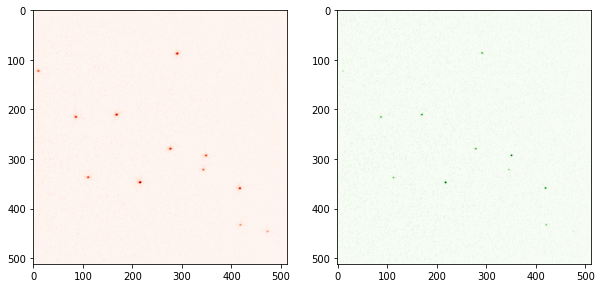

In [6]:
# Visualizing the beads
fig, ax = plt.subplots(1,2, figsize=(10, 10))
ax[0].imshow(im_beads[0,:512,:512],cmap=plt.cm.Reds);
ax[1].imshow(im_beads[1,:512,:512],cmap=plt.cm.Greens);

In [7]:
# Locating beads in the image using "tp.locate" function from trackpy.
spot_size = 5
minmass = 200
f_red = tp.locate(im_beads[0,:512,:512],spot_size, minmass,maxsize = 7,percentile = 60) # data frame for the red channel
f_green = tp.locate(im_beads[1,:512,:512],spot_size, minmass,maxsize = 7,percentile = 60)  # data frame for the green channel

In [8]:
# Converting coordenates to float32 array for the red channel
x_coord_red = np.array(f_red.x.values, np.float32)
y_coord_red = np.array(f_red.y.values, np.float32)
positions_red = np.column_stack((x_coord_red,y_coord_red ))

In [9]:
# Converting coordenates to float32 array for the green channel
x_coord_green = np.array(f_green.x.values, np.float32)
y_coord_green = np.array(f_green.y.values, np.float32)
positions_green = np.column_stack(( x_coord_green,y_coord_green ))

In [10]:
# Calculating the minimum value of rows for the alignment
no_spots_for_alignment = min(positions_red.shape[0],positions_green.shape[0])

In [11]:
# homography, status = cv2.findHomography(srcPoints, dstPoints)
#srcPoints – Coordinates of the points in the original plane, a matrix of the type CV_32FC2 or vector<Point2f> .
#dstPoints – Coordinates of the points in the target plane, a matrix of the type CV_32FC2 or a vector<Point2f> .
homography, status = cv2.findHomography(positions_green[:no_spots_for_alignment,:2],positions_red[:no_spots_for_alignment,:2])

In [12]:
# Image dimenssions.
height, width = im_beads[1,:512,:512].shape

### NO ALIGNMENT NEEDED?

In [ ]:
# IF YOUR MICROSCOPE ONLY USES A CAMERA AND NO ALIGNMENT IS NECESARY. PLEASE COMMENT THE PREVIOUS SECTION AND ONLY RUN THIS CELL. 
#homography = np.ones((3,3))
#height = 512 # 1D size of the image
#width = 512 # 1D size of the image

# Load video

The image is opened with skimage and it is converted into a numpy 4D array. The array size is (25, 512, 512, 3). The final number is not inclusive.
* Dimension 1 is the time.
* Dimension 2 is the x axis.
* Dimension 3 is the y axis.
* Dimension 4 is the number of channel.

In [13]:
# Loading video as a numpy array
vid_rem_ROI = io.imread(figName)
n_channels = vid_rem_ROI.shape[3]
n_frames =vid_rem_ROI.shape[0]

In [14]:
# Applying the alignment transformation to the whole video. Matrix multiplication to align the images from the two cameras.
for k in range(1,n_channels):
    for i in range(0,n_frames):
        vid_rem_ROI[i,:512,:512,k] = cv2.warpPerspective(vid_rem_ROI[i,:512,:512,k], homography, (width, height))

In [15]:
# Cell visualization. To start visualization simply move the time slider.
plt.rcParams["figure.figsize"] = (7,7)
def figure_viewer(drop, time):
    if drop == 'Ch_1':
        channel =0
    elif drop == 'Ch_2':
        channel = 1
    else:
        channel =2
    plt.figure(1)
    test = vid_rem_ROI[time,:512,:512,channel]
    plt.imshow(test)
    plt.show()
options = ['Ch_1', 'Ch_2', 'Ch_3']
interactive_plot = interactive(figure_viewer, drop = widgets.Dropdown(options=options,description='Channel'),time = widgets.IntSlider(min=0,max=vid_rem_ROI.shape[0]-1,step=1,value=0,description='time'))
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]
display(VBox([controls, output]))

# Mask Selection

The folliwng class is taken from the following links.
https://medium.com/@khandelwalprateek01/how-to-select-roi-in-jupyter-notebook-309fe5185a54
https://www.learnopencv.com/how-to-select-a-bounding-box-roi-in-opencv-cpp-python/

In [17]:

#      PLEASE RUN THIS TAB TWO TIMES  !!!

#      PLEASE RUN THIS TAB TWO TIMES  !!!


mpl.rc('image', cmap='jet')
plt.rcParams["figure.figsize"] = (7,7)

# This class allows the user to manually deffine a region of interes.

class bbox_select():
    %matplotlib notebook 
    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(0,0,0),3)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))

In the following step an image will be displayed and you need to select the region of interest using your mouse, click on the image to select a polygon that contains your region of interest.

<IPython.core.display.Javascript object>


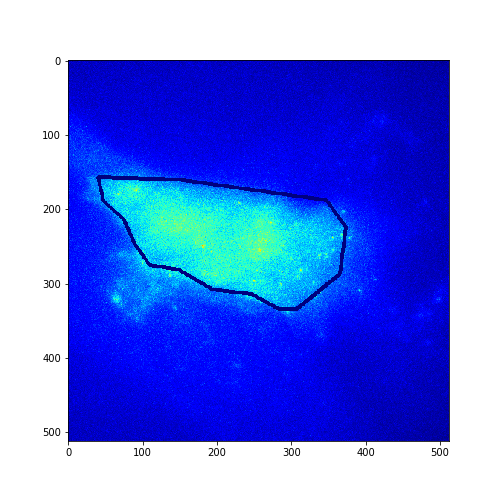

In [18]:
# if no image is shown. Please run again the previuos cell.
# Selecting the first time point and first channel
plt.rcParams["figure.figsize"] = (7,7)
test_figure =vid_rem_ROI[1,:512,:512,0] # NOTICES THAT FOR THE MASK SELECTION WE USE THE CHANNEL 2 (GREEN CHANNEL)
# Crating the interactive image editor
bs = bbox_select(test_figure)

In [19]:
# Create the mask
plt.rcParams["figure.figsize"] = (7,7)
arr = np.array([bs.selected_points],'int')
mask = cv2.fillPoly(np.zeros(test_figure.shape,np.uint8),arr,[1,1,1])

## Making zero area outside ROI

In [20]:
# Reconfigure figure style and ize
mpl.rc('figure',  figsize=(7, 7))
mpl.rc('image', cmap='gray')
mpl.rc('axes', grid=False)
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

In [21]:
## Slicing video into 3 different channels
im_ch_1 = vid_rem_ROI[:,:,:,0]    # vid_rem_ROI[:25,:512,:512,0]  # time, x-dim, y-dim, channel
im_ch_2 = vid_rem_ROI[:,:,:,1]    
im_ch_3 = vid_rem_ROI[:,:,:,2]    

### Removing max outliers. 99% percentile and 0% percentile
 Using np.where. Where True, yield x, otherwise yield y.


In [22]:
# Replacing values > 99.9% percentile 
im_ch_1_rem = np.where(im_ch_1 < np.percentile(im_ch_1, 99.99), im_ch_1, np.percentile(im_ch_1, 99.99))
im_ch_2_rem = np.where(im_ch_2 < np.percentile(im_ch_2, 99.99), im_ch_2, np.percentile(im_ch_2, 99.99))
im_ch_3_rem = np.where(im_ch_3 < np.percentile(im_ch_3, 99.99), im_ch_3, np.percentile(im_ch_3, 99.99))

## Applying a bandpass filter

In [23]:
# This sections applies a bandpass filter to the image. The idea is remove noise.
lshort = 1 # low pass filter threshold
llong = 101 # high pass filter threshold
timepoints = vid_rem_ROI.shape[0]
im_ch_1_rem = np.zeros((timepoints,512,512))
im_ch_2_rem = np.zeros((timepoints,512,512))
im_ch_3_rem = np.zeros((timepoints,512,512))
# Applying the filter to the 3 channels
for i in range(0,timepoints):
    im_ch_1_rem[i,:512,:512]= tp.bandpass(im_ch_1[i,:512,:512], lshort, llong, threshold=1, truncate=4)
    im_ch_2_rem[i,:512,:512]= tp.bandpass(im_ch_2[i,:512,:512], lshort, llong, threshold=1, truncate=4)
    im_ch_3_rem[i,:512,:512]= tp.bandpass(im_ch_3[i,:512,:512], lshort, llong, threshold=1, truncate=4)

In [24]:
## Generating arrays removing the area outside the ROI. Dot product between the mask and the studied video. This will make zero all intensity outside the ROI.
im_wo_mask_ch1n = np.multiply(im_ch_1_rem,mask)
im_wo_mask_ch2n = np.multiply(im_ch_2_rem,mask)
im_wo_mask_ch3n = np.multiply(im_ch_3_rem,mask)

In [25]:
# Creating a single 4d array containing all channels.
movie_wo_bg=np.stack([im_wo_mask_ch1n, im_wo_mask_ch2n, im_wo_mask_ch3n], axis = -1)

In [26]:
# interactive widget that displays the cell removing the region outside the mask.
plt.rcParams["figure.figsize"] = (10,10)
def figure_viewer4(drop, time):
    if drop == 'Ch_1':
        ch =0
    elif drop == 'Ch_2':
        ch =1
    else:
        ch =2    
    pt_fig =movie_wo_bg[time,:512,:512,ch]
    plt.figure(1)
    plt.imshow(pt_fig)
    plt.show()
options = ['Ch_1', 'Ch_2', 'Ch_3']
interactive_plot4 = interactive(figure_viewer4, drop = widgets.Dropdown(options=options,description='Channel'),time = widgets.IntSlider(min=0,max=vid_rem_ROI.shape[0]-1,step=1,value=0,description='time'))
controls = HBox(interactive_plot4.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot4.children[-1]
display(VBox([controls, output]))

# Particle tracking using Trackpy

The particle tracking is performed using trackpy library (http://soft-matter.github.io/trackpy/v0.4.2/).
The library documentation can be accessed in the following link: https://buildmedia.readthedocs.org/media/pdf/trackpy/v0.2.3/trackpy.pdf

## Manual selection. (Initial step)

### Visualizing the distribution for the particles' intensity

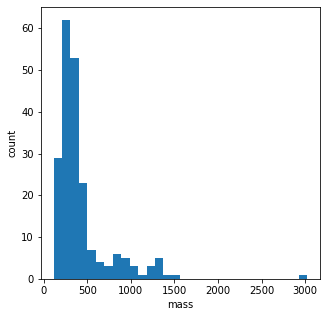

In [27]:
# This section will generate an histograme with the intensity of the detected particles in the video.

particle_size = 7 # according to the documentation must be an even number 3,5,7,9 etc.
minimal_intensity_for_selection = 100 # minimal intensity to detect a particle.

# "f" is a pandas data freame that contains the infomation about the detected spots
f = tp.locate(movie_wo_bg[0,:,:,0], particle_size, minmass=minimal_intensity_for_selection) 

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=30)
ax.set(xlabel='mass', ylabel='count');

### Using an interactive widget to select the best intensity threshold and size

In the following widget, the user is asked to manually input the particle size and the Intensity threshold, these numbers will be used for during the rest of the code to calculate intensities. Notice that tracking is only performed on channel 1, as it is usually the intensity that is constant during the movie.

In [28]:
# To start visualization move the time slider.
plt.rcParams["figure.figsize"] = (10,10) # if movie is too big, change size to (7,7)
def figure_viewer_tr(time,mass_text, drop_size):
    ch = 0  
    f = tp.locate(movie_wo_bg[time,:,:,ch],drop_size, minmass=mass_text,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
    tp.annotate(f,movie_wo_bg[time,:,:,ch]);  # tp.anotate is a trackpy function that displays the image with the detected spots  
values_size=[3,5,7,9] # Notice value must be an EVEN number.
interactive_plot_tr = interactive(figure_viewer_tr,mass_text = widgets.IntText(value=500,min=10,description='min Intensity'),drop_size = widgets.Dropdown(options=values_size,value=7,description='Particle Size'),time = widgets.IntSlider(min=0,max=vid_rem_ROI.shape[0]-1,step=1,value=0,description='Time'))
controls = HBox(interactive_plot_tr.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot_tr.children[-1]
display(VBox([controls, output])) 

### Saving the threshold parameters that will be used to define the spot selection criteria

In [29]:
# This section saves the parameters adjusted in the previous widget in two variables that will be use for the rest of the code.
selected_intensity = interactive_plot_tr.kwargs_widgets[1].value
selected_size = interactive_plot_tr.kwargs_widgets[2].value

### Detecting the spots in all frames

In [30]:
# "f" is a pandas data freame that contains the infomation about the detected spots.
# tp.batch is a trackpy function that detects spots for multiple frames in a video.
f = tp.batch(movie_wo_bg[:,:,:,0],selected_size, minmass=selected_intensity,percentile=70)

Frame 49: 38 features


### Linking all detected spots accross all frames

In [31]:
# tp.link_df is a trackpy function that links spots detected in multiple frames, this generates the spots trajectories in time.
t = tp.link_df(f,5, memory=2) # tp.link_df(data_frame, min_distance_particle_moves, min_time_particle_vanish). 

Frame 49: 38 trajectories present.


### Eliminating spurrious trajectories. 

Filter out trajectories that are detected in a few time points.

In [32]:
#trackpy.filtering.filter_stubs(tracks, threshold=100)
t1 = tp.filter_stubs(t, 10)  # selecting trajectories that appear in at least 10 frames.
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 949
After: 13


### Exporting tracks to CSV (Optional)

In [ ]:
# Optional section that saves the particles trajectories and intensities as a CSV file
# t1.to_csv(r'tracks.csv', index = False)

### Calculate the number of particles and frames

In [33]:
# Deffining the number of detected spots.
n_particles = t1['particle'].nunique()

## Plotting trajectories versus intensity using trackpy

Notice that the particle number is not consecutive, for that reason the indexing is as follows:
t1['particle'].unique()  # Where .unique() is a method that gives a numpy array with the particle names. 

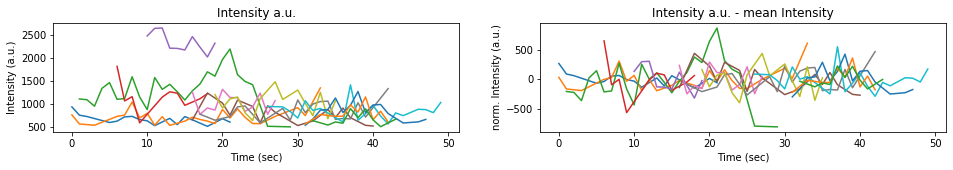

In [34]:
fig, ax = plt.subplots(1,2, figsize=(16, 2))
for id in range(0,n_particles):
    ax[0].plot(t1.loc[t1['particle']==t1['particle'].unique()[id]].frame, t1.loc[t1['particle']==t1['particle'].unique()[id]].mass)
ax[0].set(title='Intensity a.u.')
ax[0].set(xlabel='Time (sec)')
ax[0].set(ylabel='Intensity (a.u.)');

for id in range(0, n_particles):
    ax[1].plot(t1.loc[t1['particle']==t1['particle'].unique()[id]].frame,  t1.loc[t1['particle']==t1['particle'].unique()[id]].mass.values -np.mean(t1.loc[t1['particle']==t1['particle'].unique()[id]].mass.values)  )
ax[1].set(title='Intensity a.u. - mean Intensity')
ax[1].set(xlabel='Time (sec)')
ax[1].set(ylabel='norm. Intensity (a.u.)');

# Making crops for each detected particle

In [35]:
# This function is intended to center the crop based on the pixel with maximum intensity.
# The function takes a guide image, specifically the red channel. 
# and returns the centering of the additional image, based on the coordinates of the image_guide
def recenter_image_guide_and_additional(image_guide,image_additional,time,x_pos,y_pos,crop_size):
# function that recenters the spots
    sel_img = image_guide[time,y_pos-(crop_size+1):y_pos+(crop_size+1):1,x_pos-(crop_size+1):x_pos+(crop_size+1):1]
    max_coor = unravel_index(sel_img.argmax(), sel_img.shape)
    # adjusting the x-position
    if max_coor[1]> (crop_size):
        x_pos2 = x_pos + abs(max_coor[1]-crop_size)
    if max_coor[1]< (crop_size):
        x_pos2 = x_pos - abs(max_coor[1]-crop_size) 
    if max_coor[1]== (crop_size):
        x_pos2 = x_pos
    # adjusting the y-position    
    if max_coor[0]> (crop_size):
        y_pos2 = y_pos + abs(max_coor[0]-crop_size)
    if max_coor[0]< (crop_size):
        y_pos2 = y_pos - abs(max_coor[0]-crop_size)   
    if max_coor[0]== (crop_size):
        y_pos2 = y_pos    
    #recentered_image_guide = image_guide[time,y_pos2-(crop_size+1):y_pos2+(crop_size+1):1,x_pos2-(crop_size+1):x_pos2+(crop_size+1):1]
    recentered_image_additional = image_additional[time,y_pos2-(crop_size+1):y_pos2+(crop_size+1):1,x_pos2-(crop_size+1):x_pos2+(crop_size+1):1]
    return recentered_image_additional

## Centered Crops

In [36]:
# Widget to visualize the crops for the selected spot. To start visualization move the 'track' slider
def figure_viewer7(track,crop_size):
    x_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[track]].x.values[0])
    y_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[track]].y.values[0])
    fig, ax = plt.subplots(n_channels,n_frames, figsize=(20, 2))
    for i in range(0,n_channels):
        for j in range(0,n_frames):
            recentered_image = recenter_image_guide_and_additional(movie_wo_bg[:,:,:,0],movie_wo_bg[:,:,:,i],j,x_pos,y_pos,crop_size)
            ax[i,j].imshow(recentered_image,origin='bottom',cmap=plt.cm.Greys)
            ax[i,j].set_axis_off()            
values_size=[3,5,7,9,11]
n_particles_wd = t1['particle'].nunique()-1
interactive_plot7 = interactive(figure_viewer7, track = widgets.IntSlider(min=0,max=n_particles_wd,step=1,value=0,description='track'),crop_size = widgets.Dropdown(options=values_size,value=7,description='Size'))
controls = HBox(interactive_plot7.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot7.children[-1]
display(VBox([controls, output])) 

# Disk and Donut to calculate intensity.  (Tim's and Tatsuya's method)

In [37]:
# This function is inteded to calculate the intensity in each crop by deffining a disk and subsequently 
def disk_donut(test_im,disk_size,donut_size):
    def circle_coord(r,xc,yc,n_val):
        arr=[]
        theta = np.linspace(0, 2*np.pi, n_val)
        for i in range(n_val):
            y = yc + r*np.cos(theta[i])
            x = xc + r*np.sin(theta[i])
            x=int(x)
            y=int(y)
            #Create array with all the x-co and y-co of the circle
            arr.append([x,y])
        return arr
    
    # Coordinates for disk and donut
    disk_coord =circle_coord(disk_size,int(test_im.shape[0]/2),int(test_im.shape[0]/2),10)
    disk_coord = np.array([disk_coord],'int32')    
    donut_coord =circle_coord(donut_size,int(test_im.shape[0]/2),int(test_im.shape[0]/2),10)
    donut_coord = np.array([donut_coord],'int32')
    
    # Background as vector of zeros
    bg= np.zeros(test_im.shape,np.int32)
    # Creating mask for disk and donut
    mask_disk = cv2.fillPoly(bg,disk_coord,[1,1,1])    
    bg2= np.zeros(test_im.shape,np.int32)
    mask_donut = cv2.fillPoly(bg2,donut_coord,[1,1,1])

    # Create inverse mask for the disk, figure with black inside the disk
    mask_disk_inv = cv2.fillPoly(np.ones(test_im.shape,np.int32),disk_coord,[0,0,0])

    # Creating a new image for disk without background and then calculate the mean without zeros
    test_im_disk = test_im.copy()
    test_im_disk = np.multiply(test_im_disk, mask_disk)
    test_im_disk[test_im_disk == 0] = np.nan    
    means_disk = np.nanmean(test_im_disk)

    # Creating a new image for disk without background and then calculate the mean without zeros
    im_donut = np.multiply(test_im,mask_donut) # removing background
    im_donut = np.multiply(im_donut,mask_disk_inv) # removing the inside of the disk
    im_donut[im_donut == 0] = np.nan
    means_donut = np.nanmean(im_donut)
    spot_intensity_disk_donut = means_disk - means_donut
    return spot_intensity_disk_donut

### Intensity calculated with the disk and donut method

/Users/luisaguilera/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


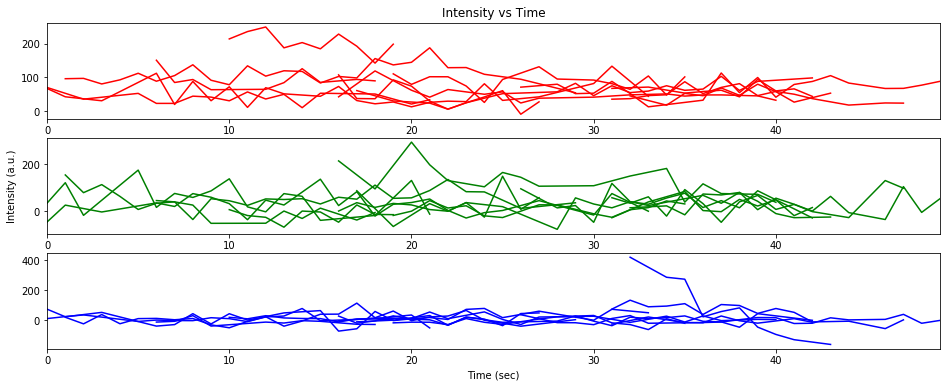

In [38]:
# Applying the disk and donut method to calculate intensity for all detected particles
crop_size = 7
disk_size = 3
donut_size = 5
arr_disk = np.zeros((n_particles,n_frames,n_channels))
time = np.arange(0,n_frames)

for k in range (0,n_particles):
    for j in range(0,n_frames):
        for i in range(0,n_channels):
            x_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[k]].x.values[0])
            y_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[k]].y.values[0])
            recentered_image = recenter_image_guide_and_additional(movie_wo_bg[:,:,:,0],movie_wo_bg[:,:,:,i],j,x_pos,y_pos,crop_size)
            arr_disk[k,j,i] = disk_donut(recentered_image,disk_size,donut_size)

fig, ax = plt.subplots(3,1, figsize=(16, 6))
for id in range (0,n_particles):
    frames_part =t1.loc[t1['particle']==t1['particle'].unique()[id]].frame.values
    ax[0].plot(t1.loc[t1['particle']==t1['particle'].unique()[id]].frame.values, arr_disk[id,frames_part,0],'r')
    ax[1].plot(t1.loc[t1['particle']==t1['particle'].unique()[id]].frame.values, arr_disk[id,frames_part,1],'g')
    ax[2].plot(t1.loc[t1['particle']==t1['particle'].unique()[id]].frame.values, arr_disk[id,frames_part,2],'b')
ax[0].set(title='Intensity vs Time')
ax[2].set(xlabel='Time (sec)')
ax[1].set(ylabel='Intensity (a.u.)')
ax[0].set_xlim([0, n_frames-1])
ax[1].set_xlim([0, n_frames-1])
ax[2].set_xlim([0, n_frames-1])
plt.show()            

# Spot classification (Automatic)

### Categorizing into Red-only, Yellow, Purple, and White Spots

The spots are classified as follows:
* Red-only = Channel_1 (+)
* Yellow = Channel_1 (+) Channel_2 (+) 
* Purple = Channel_2 (+) Channel_3 (+)
* White = Channel_1 (+) Channel_2 (+) Channel_3 (+) 

## Visualizing the average of all tracks for each channel

In [39]:
def figure_viewer9(track):
    crop_size = 7
    disk_size = 3
    donut_size = 5
    size_crop_image = recentered_image.shape[0]
    temp_recentered_image2 = np.zeros((n_frames,size_crop_image,size_crop_image))
    mean_image_ch2 = np.zeros((n_channels,size_crop_image,size_crop_image))

    frames_part=t1.loc[t1['particle']==t1['particle'].unique()[track]].frame.values
    for i in range(0,n_channels):
        for j in frames_part:  #n_frames
            x_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[track]].x.values[0])
            y_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[track]].y.values[0])
            temp_recentered_image2[j,:,:] = recenter_image_guide_and_additional(movie_wo_bg[:,:,:,0],movie_wo_bg[:,:,:,i],j,x_pos,y_pos,crop_size)
        mean_image_ch2[i,:,:] = np.mean(temp_recentered_image2[frames_part[0]:frames_part[-1],:,:], axis = 0)

    fig, ax = plt.subplots(1,n_channels, figsize=(10, 5))
    for i in range(0,n_channels):
        ax[i].imshow(mean_image_ch2[i,:,:],origin='bottom',cmap=plt.cm.Greys)
        ax[i].set_axis_off()  

interactive_plot9 = interactive(figure_viewer9, track = widgets.IntSlider(min=0,max=n_particles-1,step=1,value=0,description='track'))
interactive_plot9
# Channel_1 (Red)      # Channel_2 (Green)    # Channel_3 (Blue)

interactive(children=(IntSlider(value=0, description='track', max=12), Output()), _dom_classes=('widget-intera…

## Spot Classification (Automatic)

/Users/luisaguilera/anaconda3/lib/python3.7/site-packages/trackpy/feature.py:429: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
/Users/luisaguilera/anaconda3/lib/python3.7/site-packages/trackpy/find.py:133: UserWarning: All local maxima were in the margins.
  warnings.warn("All local maxima were in the margins.", UserWarning)


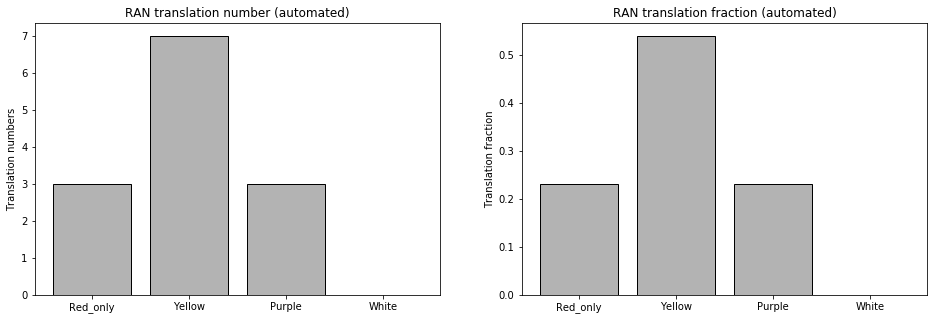

In [40]:
# Section that reads the average crop and runs trackpy to detect particules inside the crop
# Notice that this section takes some minutes to run as it is applying "tp.locate" function to each crop and channel. 

# This section saves an average image for all crops where a spot is dected by trackpy.
size_crop_image = recentered_image.shape[0]
temp_recentered_image1 = np.zeros((n_frames,size_crop_image,size_crop_image))
mean_image_ch = np.zeros((n_channels,size_crop_image,size_crop_image))
mean_all_particles_all_ch = np.zeros((n_channels,size_crop_image,size_crop_image,n_particles+1))
for k in range (0,n_particles):
    for i in range(0,n_channels):
        for j in range(0,n_frames):
            frames_part=t1.loc[t1['particle']==t1['particle'].unique()[k]].frame.values
            x_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[k]].x.values[0])
            y_pos=int(t1.loc[t1['particle']==t1['particle'].unique()[k]].y.values[0])
            temp_recentered_image1[j,:,:] = recenter_image_guide_and_additional(movie_wo_bg[:,:,:,0],movie_wo_bg[:,:,:,i],j,x_pos,y_pos,crop_size)
        mean_all_particles_all_ch [i,:,:,k] = np.mean(temp_recentered_image1[frames_part[0]:frames_part[-1],:,:], axis = 0)
        
# This section uses trackpy to detect particles in the average image. Based on detection, it classifies the spot as red, yellow, purple, white
min_intensity = 400 # adjust this parameter according to your image
particle_size = 7 # adjust this parameter according to your image
particle_classification = np.zeros((n_particles,n_channels)) # Prealocating memory
for k in range (0,n_particles):
    for i in range(0,n_channels):
        f = tp.locate(mean_all_particles_all_ch [i,:,:,k],particle_size, min_intensity)
        if f.y.values.size >0:
            particle_classification [k,i] = 1

# Automatic classification 

# Converting intensity =1 if int>threshold, 0 otherwise
red_spots = particle_classification[:,0] # Where True, yield x, otherwise yield y.
green_spots = particle_classification[:,1] # Where True, yield x, otherwise yield y.
blue_spots = particle_classification[:,2] # Where True, yield x, otherwise yield y.

# Spot classification is based on logical operations in each element of the array. For example, a white spot exist if red_spots(=1) *green_spots (=1) *blue_spots (=1) 
White = red_spots*green_spots*blue_spots 
Purple = (red_spots*blue_spots) - White
Yellow = (red_spots*green_spots) - White
Red_only = red_spots*(1-green_spots)*(1-blue_spots)

# Number of spots is obtained by the sum.
num_White =  sum(White)
num_Purple = sum(Purple)
num_Yellow = sum(Yellow)
num_Red_only = sum(Red_only)

# total number of spots
total_no_spots = num_White + num_Purple + num_Yellow + num_Red_only

# Fractions
frac_White =  num_White/total_no_spots
frac_Purple = num_Purple/total_no_spots
frac_Yellow = num_Yellow/total_no_spots
frac_Red_only = num_Red_only/total_no_spots

# Plotting calculated numbers
objects = ('Red_only', 'Yellow', 'Purple', 'White')
x_pos = np.arange(len(objects))
number_spots = [num_Red_only,num_Yellow,num_Purple,num_White]
fractions = [frac_Red_only,frac_Yellow,frac_Purple,frac_White]

fig, ax = plt.subplots(1,2, figsize=(16, 5))

ax[0].bar(x_pos, number_spots, align='center', color= (0.7,0.7,0.7),edgecolor='k',linewidth=1)
#ax[0].set(xticks = x_pos, objects)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(objects)
ax[0].set(ylabel='Translation numbers')
ax[0].set(title='RAN translation number (automated)');

ax[1].bar(x_pos, fractions, align='center',color= (0.7,0.7,0.7),edgecolor='k',linewidth=1)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(objects)
ax[1].set(ylabel='Translation fraction')
ax[1].set(title='RAN translation fraction (automated)');

## Spot Classification (Manual)

This section is intended to ask the user to double check if the automatic classification is correct. Running the next section will take a minute to load. Please mark the case that represents the correct classification.

In [41]:
sel_part = mean_all_particles_all_ch.copy()
x = np.linspace(0, recentered_image.shape[0]-1, recentered_image.shape[0])
y = np.linspace(0, recentered_image.shape[0]-1, recentered_image.shape[0])
x_sc, y_sc, col_sc = LinearScale(), LinearScale(), ColorScale(scheme='Greys') #gist_yarg Greys Greys
aspect_ratio = 1
grid = GridspecLayout(n_particles, 4, height='100', width="80%") # , width='200px'
for k in range (0,n_particles):
    for i in range(0,3):        
        ht_map = HeatMap(x=x, y=y, color=sel_part[i,:,:,k]/np.max(sel_part[i,:,:,k]),scales={'x': x_sc, 'y': y_sc, 'color': col_sc},layout=Layout(width='10px', height='10px',flex_flow='row',display='flex'))
        fig = bq.Figure(marks=[ht_map], padding_y=0.0,padding_x=0.0,min_aspect_ratio=aspect_ratio, max_aspect_ratio=aspect_ratio,fig_margin=dict(top=0, bottom=0, left=0, right=0))
        grid[k,i] = fig
        grid[k,i].layout.height =  'auto'
    for i in range(3,4): 
       # grid[k,i] = widgets.Checkbox(value=val,description=spot_type,disabled=False,indent=False, layout=Layout(flex='1 1 0%', width='auto'))
        if White[k] ==1:
            value_auto = 'White(R,G,B)'
        elif Purple[k] ==1:
            value_auto = 'Purple(R,B)'
        elif Yellow[k] ==1:
            value_auto = 'Yellow(R,G)'
        elif Red_only[k] ==1:
            value_auto = 'Red_only(R)'        
        grid[k,i] = widgets.RadioButtons(options=['Red_only(R)', 'Yellow(R,G)', 'Purple(R,B)','White(R,G,B)', 'Reject'],   value = value_auto, layout={'width': 'max-content'}, description='Spot type:',disabled=False)
        grid[k,i].layout.height = 'auto'
grid

# The figure below requieres you to check track by track and visualy check if there is a missclassification.
# In case you detect a missclasification, please correct by selecting the value at the right hand side of the figure.


# Channel_1 (Red)      # Channel_2 (Green)    # Channel_3 (Blue)

GridspecLayout(children=(Figure(fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0}, layout=Layout(grid_…

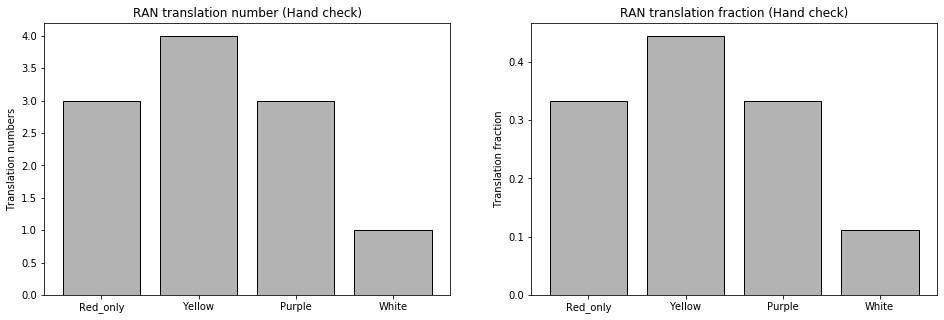

In [42]:
# Plotting the classification after manually checking the results.

# Read all check boxes and classify the spots
chbox_White = np.zeros((n_particles))
chbox_Purple = np.zeros((n_particles))
chbox_Yellow = np.zeros((n_particles))
chbox_Red_only = np.zeros((n_particles))
chbox_Rejected = np.zeros((n_particles)) # If an spot is ambiguos, you can simply select Reject and the spot won't be considered.

for id in range (0,n_particles):
    if grid[id,3].value == 'White(R,G,B)':
        chbox_White[id] = 1
    elif grid[id,3].value == 'Purple(R,B)':
        chbox_Purple[id] = 1
    elif grid[id,3].value == 'Yellow(R,G)':
        chbox_Yellow[id] = 1
    elif grid[id,3].value == 'Red_only(R)':
        chbox_Red_only[id] = 1
    elif grid[id,3].value == 'Reject':
        chbox_Rejected[id] = 1
        
# Numbers
hc_num_White =  sum(chbox_White)
hc_num_Purple = sum(chbox_Purple)
hc_num_Yellow = sum(chbox_Yellow)
hc_num_Red_only = sum(chbox_Red_only)
hc_num_Rejected = sum(chbox_Rejected)

# total number of spots
total_no_spots = hc_num_White + hc_num_Purple + hc_num_Yellow + hc_num_Red_only - hc_num_Rejected

# Fractions
hc_frac_White =  hc_num_White/total_no_spots
hc_frac_Purple = hc_num_Purple/total_no_spots
hc_frac_Yellow = hc_num_Yellow/total_no_spots
hc_frac_Red_only = hc_num_Red_only/total_no_spots   

# Plotting manually classified number of spots
objects = ('Red_only', 'Yellow', 'Purple', 'White')
x_pos = np.arange(len(objects))
number_spots = [hc_num_Red_only,hc_num_Yellow,hc_num_Purple,hc_num_White]
fractions = [hc_frac_Red_only,hc_frac_Yellow,hc_frac_Purple,hc_frac_White]

fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].bar(x_pos, number_spots, align='center', color= (0.7,0.7,0.7),edgecolor='k',linewidth=1)
#ax[0].set(xticks = x_pos, objects)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(objects)
ax[0].set(ylabel='Translation numbers')
ax[0].set(title='RAN translation number (Hand check)');

ax[1].bar(x_pos, fractions, align='center',color= (0.7,0.7,0.7),edgecolor='k',linewidth=1)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(objects)
ax[1].set(ylabel='Translation fraction')
ax[1].set(title='RAN translation fraction (Hand check)');

### Saving the results

In [43]:
# This section will save the final fraction and percentage as a file in your local folder, the file is saved as comma separated value.
from sys import platform
if platform == "linux" or platform == "linux2":
    start_name = figName.find('/')+1
elif platform == "darwin":
    start_name = figName.find('/')+1
elif platform == "win32":
    start_name = figName.find('\'')
    
start_name = max(0, start_name)

fileName = figName[start_name:-4] # the name of the file is generated using the name of the video.
np.savetxt('numbers_'+fileName+'.csv', (number_spots), delimiter=',')
np.savetxt('fractions_'+fileName+'.csv', (fractions), delimiter=',')